In [14]:
%load_ext autoreload
%autoreload 2

import torch
import torch.nn as nn
from torchvision import datasets, transforms
from tqdm import tqdm
import matplotlib.pyplot as plt
from admm.agents import FedConsensus
from admm.models import mnistNet
from admm.utils import add_params, average_params, sum_params

%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Load MNIST data and create loaders

In [15]:
train_ratio = 0.8
val_ratio = 0.1
test_ratio = 0.1
batch_size = 64

# Define transformations
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.1307,), (0.3081,))])

# Load the full MNIST dataset and filter for 1's and 2's
dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=False)
filtered_dataset = [data for data in dataset if data[1] == 1 or data[1] == 2]

# Split into train, val and test
dataset_length = len(filtered_dataset)
train_length = int(train_ratio * dataset_length)
val_length = int(val_ratio * dataset_length)
test_length = dataset_length - train_length - val_length
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(
    filtered_dataset, 
    [train_length, val_length, test_length]
)

digit_1_train_dataset = [data for data in train_dataset if data[1] == 1]
digit_2_train_dataset = [data for data in train_dataset if data[1] == 2]
digit_1_train_loader = torch.utils.data.DataLoader(digit_1_train_dataset, batch_size=batch_size, shuffle=True)
digit_2_train_loader = torch.utils.data.DataLoader(digit_2_train_dataset, batch_size=batch_size, shuffle=True)

val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

### Visualise data

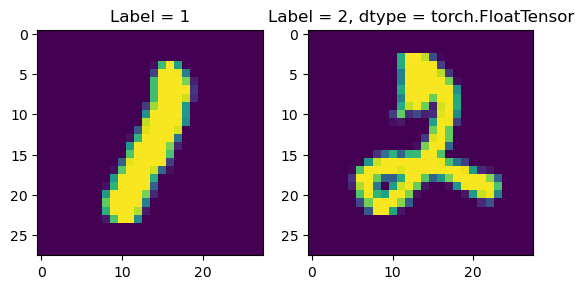

In [16]:
for data, target in digit_1_train_loader:
    data = data[0,:,:,:]
    plt.subplot(1,2,1)
    plt.imshow(data.permute(1,2,0))
    plt.title(f'Label = {target[0].item()}')
    break

for data, target in digit_2_train_loader:
    shape = data.shape
    data = data[0,:,:,:]
    plt.subplot(1,2,2)
    plt.imshow(data.permute(1,2,0))
    plt.title(f'Label = {target[0].item()}, dtype = {target.float().type()}')
    break

### Define Agents

In [27]:
delta = 0
rho = 0.01
loaders = [digit_1_train_loader, digit_2_train_loader]
agents = [
    FedConsensus(
        N=len(loaders),
        delta=delta,
        rho=rho,
        model=mnistNet(in_channels=784, hidden1=400, hidden2=400, out_channels=10),
        loss=nn.CrossEntropyLoss(),
        train_loader=loader,
        classification=True,
        epochs=5
    ) for loader in loaders
]

# Broadcast average to all agents and check if equal
for agent in agents:
    agent.primal_avg = average_params([agent.model.parameters() for agent in agents])
for param1, param2 in zip(agents[0].primal_avg, agents[1].primal_avg):
    if not torch.equal(param1, param2): print('param not equal')

In [28]:
comm = 0
t_max = 500
for t in tqdm(range(t_max)):
    
    # Primal Update
    for agent in agents:
        agent.primal_update()

    # Residual update in the case of communication
    C = []
    for agent in agents:
        if agent.broadcast: 
            comm += 1
            C.append(agent.residual)
    if C:
        # If communicaiton set isn't empty
        residuals = [x for x in sum_params(C)]
        for agent in agents:
            add_params(agent.primal_avg, residuals)

    # Dual update
    for agent in agents:
        agent.dual_update()

100%|██████████| 200/200 [03:37<00:00,  1.09s/it]


In [67]:
[agent1, agent2] = agents

for data, target in val_loader:
    data = data.reshape(-1, 28*28)
    out1 = torch.argmax(agent1.model(data), dim=1)
    out2 = torch.argmax(agent2.model(data), dim=1)
    print(f'model1 = {1 - torch.count_nonzero(out1-target)/len(target)}')
    print(f'\nmodel2 = {1 - torch.count_nonzero(out2-target)/len(target)}')
    # print(f'\ntarget = {target[:5]}')
    break
    

model1 = 0.78125

model2 = 0.390625
